In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")

from src.masked.kernel import VFTSGaussKernel,TSGaussGaussKernel
from src.masked.loss import VarifoldLoss
from src.masked.lddmm import Shooting,Flowing
from src.plotting import plot2Dfigure

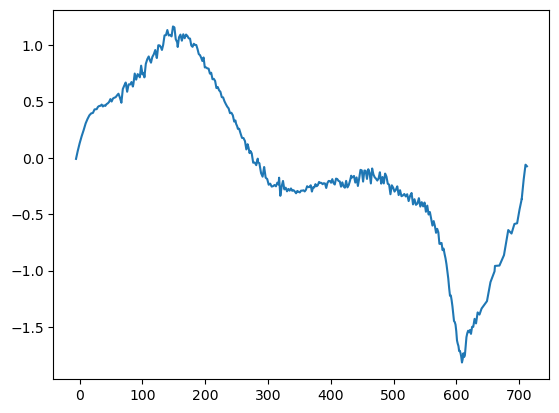

In [2]:
np.random.seed(0)

y =pd.read_csv("./dataset/y.csv",index_col=0)
X = np.load("./dataset/X.npy")
X_mask = np.load("./dataset/X_mask.npy")
idxs = np.load("./results/exp_2_2/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/exp_2_2/p0s.npy")
q0 = np.load("./results/exp_2_2/q0.npy")
q0_mask = np.load("./results/exp_2_2/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(*q0[q0_mask.squeeze(),:].T)

In [3]:
np.sum(q0_mask)

349

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

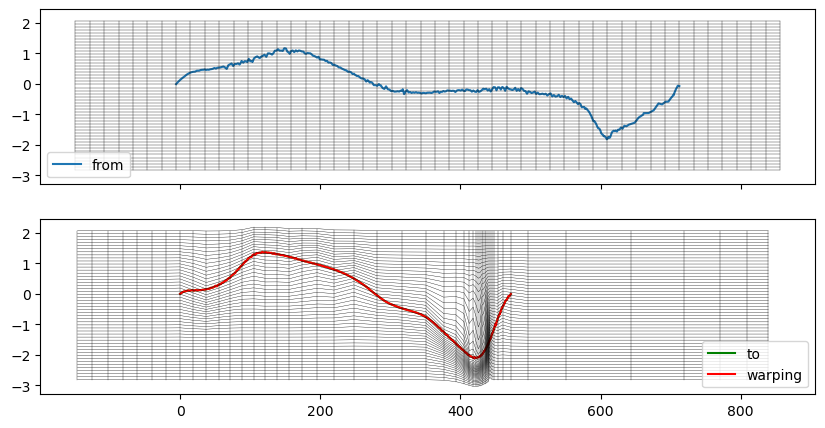

In [4]:
Kv = VFTSGaussKernel(1,0.1,150,1,1)
Kl = TSGaussGaussKernel(5,1,5,0.6)
dataloss = VarifoldLoss(Kl)

shoot = Shooting(Kv)
flow = Flowing(Kv)

plot2Dfigure(q0,X[0],p0s[0],shoot,flow,q0_mask,X_mask[0])

In [5]:
p0s.shape

(1050, 1000, 2)

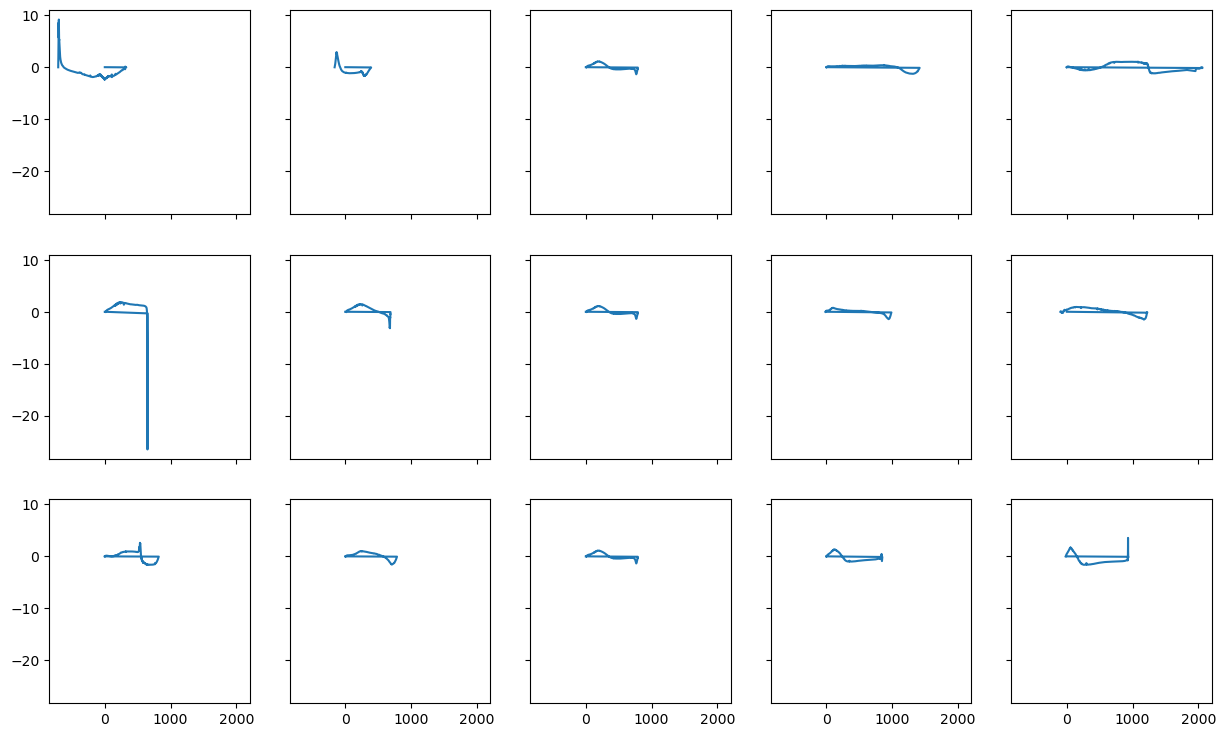

In [6]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,5
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*3,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for alpha in np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(*q.T)
        k += 1
plt.show()

In [7]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(ncomp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
df

,filename,genotype,before,start,end,mouse_id,PC1,PC2,PC3,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,colq_1,-301.895691,-106.756767,57.424370,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,colq_1,-324.478485,-160.069046,94.570511,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,colq_1,-388.621857,-136.656250,112.561058,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,colq_1,-350.130859,-117.664551,88.384857,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,colq_1,-358.928009,-146.096176,92.490356,17.832642
...,...,...,...,...,...,...,...,...,...,...
12556,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,N,1362588,1364456,wt_7,1072.076050,-379.561646,36.017590,31.162842
12710,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,N,3226114,3227145,wt_7,22.757149,335.597260,-40.777481,46.692225
12635,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,N,2343987,2345657,wt_7,895.799316,-224.208176,62.506126,39.341167
12679,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,N,2866496,2867975,wt_7,692.826111,-16.647898,119.153343,43.695408


In [8]:
import seaborn as sns

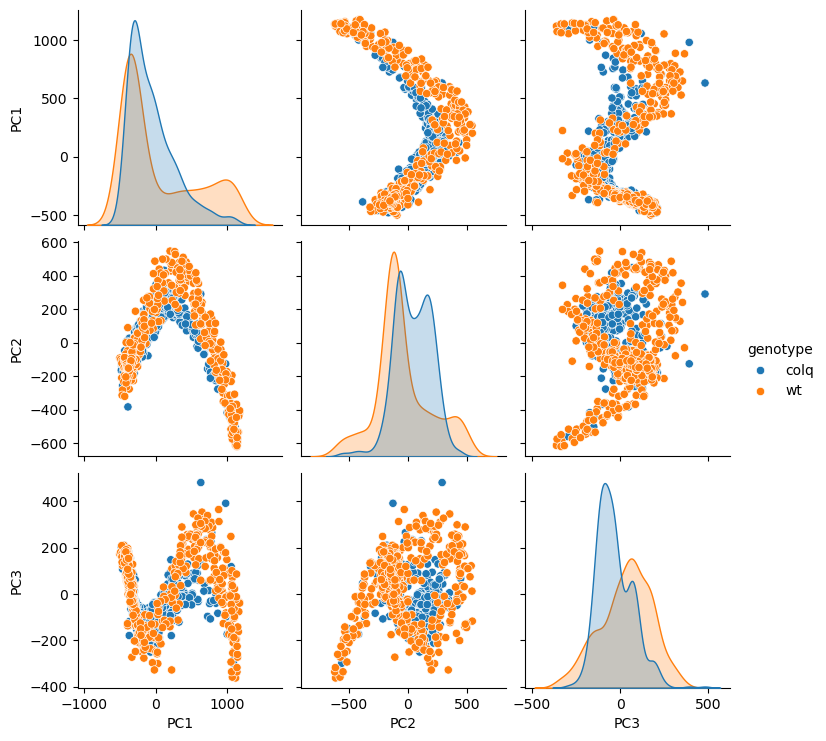

In [9]:
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(ncomp)])

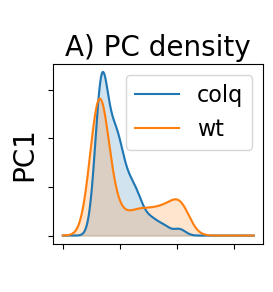

In [30]:
from scipy.stats import gaussian_kde
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(ncomp)]
span =1.0
nsample = 10000
ft_size = 20
pft_size = 16



fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (3,3))
r = df["PC1"].values.max()
l = df["PC1"].values.min()
x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
for gen,color in color_mapping.items(): 
    arr = df[df.genotype == gen]["PC1"].values
    y = gaussian_kde(arr)(x)
    ax.plot(x,y,color=color,label=gen)
    ax.fill_between(x,y,color=color,alpha=0.2)
    ax.set_ylabel("PC1",fontsize=ft_size)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(fontsize=pft_size)
ax.set_title("A) PC density",fontsize=ft_size)
ax.set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./exp_2_density.jpeg",format="jpeg")

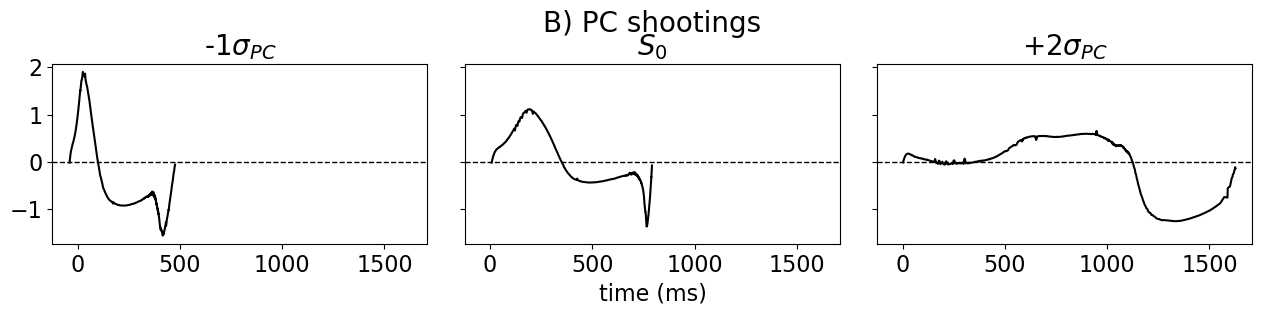

In [31]:
from src.statistic import MomentaPCA
ncomp,ndisp = 1,3
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*5,3),sharex=True,sharey=True)
sigma_pca = np.std(mpca.p_score_[:,0])
for j,alpha in enumerate(np.array([-1,0,2])*sigma_pca):
    p0_mode = p0_bar + alpha * mpca.p_pc_[0]
    p,q = shoot(p0_mode,q0,q0_mask)
    axs[j].plot(*q[q0_mask.squeeze()].T,color="black")

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0].set_title(r"-1$\sigma_{PC}$",fontsize=ft_size)
axs[1].set_title(r"$S_0$",fontsize=ft_size)
axs[2].set_title(r"+2$\sigma_{PC}$",fontsize=ft_size)
for ax in axs:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs:
    ax.yaxis.set_tick_params(labelsize=pft_size)

fig.suptitle("B) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./exp_2_shooting.jpeg",format="jpeg")


/tmp/ipykernel_466522/3913809191.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('plasma')
/tmp/ipykernel_466522/3913809191.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)


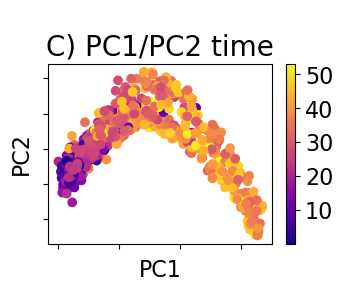

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,3))
x = df.PC1.values
y = df.PC2.values
c = df.time.values
cm = plt.cm.get_cmap('plasma')
sc = ax.scatter(x,y,c=c,cmap = cm)
cbar = fig.colorbar(sc)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)
    

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("C) PC1/PC2 time",fontsize=ft_size)
ax.set_ylabel("PC2",fontsize=pft_size)
ax.set_xlabel("PC1",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./exp_2_time.jpeg",format="jpeg")

In [27]:
ticklabs

[Text(1, 0.0, '0'),
 Text(1, 20.0, '10'),
 Text(1, 40.0, '20'),
 Text(1, 60.0, '30'),
 Text(1, 40.0, '40'),
 Text(1, 50.0, '50'),
 Text(1, 60.0, '60')]

In [28]:
idxs = np.argsort(pdf.PC1.values)[::-1]

NameError: name 'pdf' is not defined

In [ ]:
idxs

array([ 5,  4,  6,  3,  8,  9,  1,  0,  7, 10, 12, 11,  2, 13])

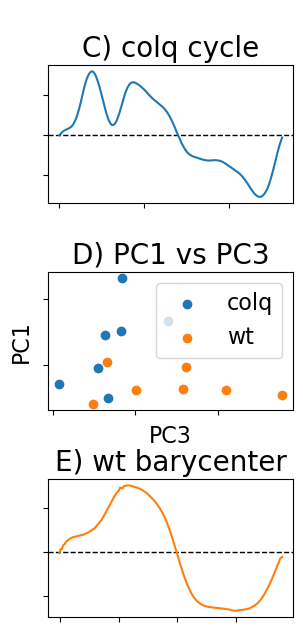

In [ ]:
fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3.5,ncomp*2.3))

idxs = np.argsort(df.PC1.values)[::-1]
idx = idxs[154]
q = X[idx]
q_mask = X_mask[idx]
axs[0].set_title("C) colq cycle",fontsize =ft_size)
axs[0].plot(*q[q_mask.squeeze()].T,color = color_mapping["colq"])
axs[0].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_title("D) PC1 vs PC3",fontsize =ft_size)
c = pdf[pdf.genotype == "colq"][["PC3","PC1"]].values
axs[1].scatter(*c.T,color=color_mapping["colq"],label="colq")
w = pdf[pdf.genotype == "wt"][["PC3","PC1"]].values
axs[1].scatter(*w.T,color = color_mapping["wt"],label="wt")
axs[1].set_xlabel("PC3", fontsize=pft_size)
axs[1].set_ylabel("PC1", fontsize=pft_size)

axs[2].set_title("E) wt barycenter",fontsize =ft_size)
idx = pdf.PC3.argmax()
axs[2].plot(*qs[idx][qs_mask[idx].squeeze()].T,color= color_mapping["wt"])
axs[2].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[1].legend(fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)

fig.savefig("./exp_1_exemple.jpeg",format="jpeg")
